# **TimeGAN**
Unofficial implementation in PyTorch 2.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

Notebook Author: https://github.com/haufjan

### **Import**

In [ ]:
import os
from time import gmtime, strftime, time
from itertools import chain
import numpy as np
import pandas as pd
import torch
from torch import nn, tensor, Tensor
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

### **Functions**

In [ ]:
def load_dataset(file_path: str) -> np.ndarray:
    """
    Load benchmark data set from CSV file
    """
    file_path = file_path if file_path.endswith('csv') else file_path + '.csv'
    if file_path.endswith(('stock_data.csv', 'energy_data.csv')):
        # Flip data for chronological order
        benchmark_data = np.asarray(pd.read_csv(file_path))[::-1]
    else:
        rng = np.random.default_rng(seed=42)
        sine_signal = []
        for _ in range(5):
            # Randomly drawn frequency and phase
            frequency = rng.uniform(0, 0.1)
            phase = rng.uniform(0, 0.1)
            sine_signal.append([np.sin(frequency * j + phase) for j in range(10000)])

        benchmark_data = np.stack(np.transpose(np.asarray(sine_signal)))

    return benchmark_data

In [ ]:
def preprocessing(data, sequence_length: int, use_scaling: bool = True, use_shuffling: bool = True, random_state: int = None) -> np.ndarray | tuple:
    """
    Conduct preprocessing: scale data, slice data into sequences and shuffle data stack

    Args:
        data: Raw input data
        sequence_length (int): Length of the sequences to be created
        use_scaling (bool): Default = True; Apply Min-Max scaling
        use_shuffling (bool): Default = True; Shuffle data stack
        random_state (int): Default = None; No random state
    Returns:
        np.ndarray | tuple: Preprocessed data stack or tuple of data stack, max values, and min values
    """
    # Minimum-Maximum scaling
    if use_scaling:
        scaler = MinMaxScaler().fit(data)
        data = scaler.transform(data)
        print('\nMaximum values:\n', scaler.data_max_, '\nMinimum values:\n', scaler.data_min_)

    # Create list of sequences defined by sequence_length and stack to a 3-dimensional array (batch, sequence_length, feature)
    data_stack = np.stack([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

    if use_shuffling:
        # In TimeGAN code the data set is mixed to make it similar to independent and identically distributed (iid)
        data_stack = shuffle(data_stack, random_state=random_state)

    return (data_stack, scaler.data_max_, scaler.data_min_) if use_scaling else data_stack

### **Load and Prepare Data**

In [ ]:
# Data set
data = load_dataset(os.path.join('stock_data'))

# Squence length
seq_len = 24

# Preprocess data
data_train, max_val, min_val = preprocessing(data, seq_len)


Maximum values:
 [1.27100000e+03 1.27389001e+03 1.24902002e+03 1.26832996e+03
 1.26832996e+03 8.27681000e+07] 
Minimum values:
 [  49.274517   50.541279   47.669952   49.681866   49.681866 7900.      ]


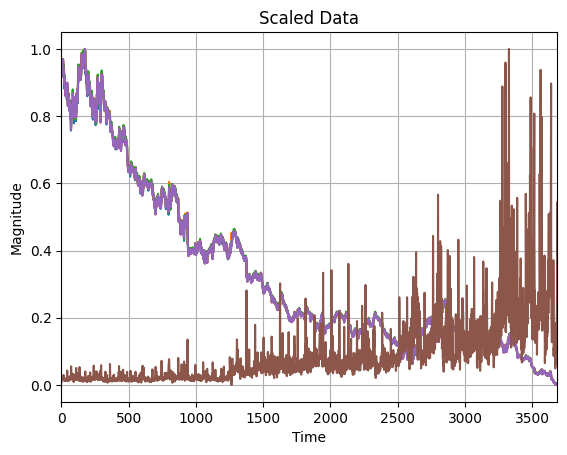

In [ ]:
# Visualize scaled training data
fig, ax = plt.subplots()
ax.plot((data - min_val)/(max_val - min_val))
ax.set_xlim(0, len(data))
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Scaled Data')
ax.grid(True)
fig.show()

### **Device**

In [ ]:
def get_device() -> str:
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    print(f'Using {device} device')
    return device

device = get_device()

Using cuda device


### **TimeGAN Networks**

##### **Embedder**

In [ ]:
class Embedder(nn.Module):
    def __init__(self, module_name: str, input_features: int, hidden_dim: int, num_layers: int):
        super().__init__()

        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x: Tensor) -> Tensor:
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Recovery**

In [ ]:
class Recovery(nn.Module):
    def __init__(self, module_name: str, input_features: int, hidden_dim: int, num_layers: int):
        super().__init__()

        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.model = nn.Sequential(nn.Linear(hidden_dim, input_features),
                                   nn.Sigmoid())

    def forward(self, x: Tensor) -> Tensor:
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Generator**

In [ ]:
class Generator(nn.Module):
    def __init__(self, module_name: str, input_features: int, hidden_dim: int, num_layers: int):
        super().__init__()

        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=input_features, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x: Tensor) -> Tensor:
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Supervisor**

In [ ]:
class Supervisor(nn.Module):
    def __init__(self, module_name: str, hidden_dim: int, num_layers: int):
        super().__init__()

        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers-1, batch_first=True)
        else:
            raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        self.model = nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                   nn.Sigmoid())

    def forward(self, x: Tensor) -> Tensor:
        seq, _ = self.rnn(x)
        return self.model(seq)

##### **Discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, module_name: str, hidden_dim: int, num_layers: int):
        super().__init__()

        if module_name == 'gru':
            self.rnn = nn.GRU(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=False, batch_first=True)
        elif module_name == 'lstm':
            self.rnn = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=False, batch_first=True)
        else:
            raise ValueError(f"Invalid module name {module_name}. Choose 'gru' or 'lstm'.")
        # If bidirectional = True
        # self.model = nn.Linear(2*hidden_dim, 1)
        # If bidirectional = False
        self.model = nn.Linear(hidden_dim, 1)

    def forward(self, x: Tensor) -> Tensor:
        seq, _ = self.rnn(x)
        return self.model(seq)

### **Loss Functions**

In [ ]:
def embedder_loss(x: Tensor, x_tilde: Tensor) -> Tensor:
    return 10*torch.sqrt(nn.MSELoss()(x_tilde, x))

In [ ]:
def supervised_loss(h: Tensor, h_hat_supervise: Tensor) -> Tensor:
    return nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

In [ ]:
def generator_loss(y_fake: Tensor,
                   y_fake_e: Tensor,
                   h: Tensor,
                   h_hat_supervise: Tensor,
                   x: Tensor,
                   x_hat: Tensor) -> Tensor:
    gamma = 1
    fake = torch.ones_like(y_fake, dtype=torch.float32, device=y_fake.device, requires_grad=False)

    # 1. Unsupervised generator loss
    g_loss_u = nn.BCEWithLogitsLoss()(y_fake, fake)
    g_loss_u_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    # 2. Supervised loss
    g_loss_s = nn.MSELoss()(h_hat_supervise[:,:-1,:], h[:,1:,:])

    # 3. Two moments
    g_loss_v1 = torch.mean(torch.abs(torch.sqrt(torch.std(x_hat, dim=0)) - torch.sqrt(torch.std(x, dim=0))))
    g_loss_v2 = torch.mean(torch.abs(torch.mean(x_hat, dim=0) - torch.mean(x, dim=0)))
    g_loss_v = g_loss_v1 + g_loss_v2

    return g_loss_u + gamma*g_loss_u_e + 100*torch.sqrt(g_loss_s) + 100*g_loss_v

In [ ]:
def discriminator_loss(y_real: Tensor, y_fake: Tensor, y_fake_e: Tensor) -> Tensor:
    gamma = 1
    valid = torch.ones_like(y_real, dtype=torch.float32, device=y_real.device, requires_grad=False)
    fake = torch.zeros_like(y_fake, dtype=torch.float32, device=y_fake.device, requires_grad=False)

    d_loss_real = nn.BCEWithLogitsLoss()(y_real, valid)
    d_loss_fake = nn.BCEWithLogitsLoss()(y_fake, fake)
    d_loss_fake_e = nn.BCEWithLogitsLoss()(y_fake_e, fake)

    return d_loss_real + d_loss_fake + d_loss_fake_e*gamma

### **TimeGAN**

In [ ]:
class TimeGAN(nn.Module):
    """
    TimeGAN model for time series generation
    """
    def __init__(self,
                 module_name: str = 'gru',
                 input_features: int = 1,
                 hidden_dim: int = 8,
                 num_layers: int = 3,
                 epochs: int = 1000,
                 batch_size: int = 128,
                 learning_rate: float = 1e-3,
                 device: str = 'cpu'):
        """
        Args:
            module_name (str): Name of the recurrent module ('gru' or 'lstm')
            input_features (int): Number of input features
            hidden_dim (int): Number of hidden units
            num_layers (int): Number of recurrent layers
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            learning_rate (float): Learning rate for optimizer
            device (str): Device to use for training ('cpu' or 'cuda')
        """
        super().__init__()

        # Attributes
        self.module_name = module_name
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.device = device

        # Networks
        self.embedder = Embedder(module_name, input_features, hidden_dim, num_layers)
        self.recovery = Recovery(module_name, input_features, hidden_dim, num_layers)
        self.generator = Generator(module_name, input_features, hidden_dim, num_layers)
        self.supervisor = Supervisor(module_name, hidden_dim, num_layers)
        self.discriminator = Discriminator(module_name, hidden_dim, num_layers)

        # Optimizers
        self.optimizer_e = torch.optim.Adam(chain(self.embedder.parameters(), self.recovery.parameters()), lr=learning_rate)
        self.optimizer_g = torch.optim.Adam(chain(self.generator.parameters(), self.supervisor.parameters()), lr=learning_rate)
        self.optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)

        # Loss functions
        self.embedder_loss = embedder_loss
        self.supervised_loss = supervised_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

        # Auxiliary
        self.fitting_time = None
        self.losses = []

    def fit(self, data_train: np.ndarray) -> None:
        """
        Train TimeGAN model in three subsequent training phases
        """
        self.fitting_time = time()
        data_train = tensor(data_train, dtype=torch.float32, device=self.device)

        # 1. Embedding network training
        print('Start Embedding Network Training')
        for epoch in range(self.epochs):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_e = []
            for x in batches_train:
                self.optimizer_e.zero_grad()

                h = self.embedder(x)
                x_tilde = self.recovery(h)
                e_loss = self.embedder_loss(x, x_tilde)

                e_loss.backward()
                self.optimizer_e.step()

                loss_e.append(e_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_e', f'{np.mean(loss_e):12.9f}')

        print('Finished Embedding Network Training\n')

        # 2. Training using only supervised loss
        print('Start Training with Supervised Loss Only')
        for epoch in range(self.epochs):
            batches_train = DataLoader(data_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_g = []
            for x in batches_train:
                self.optimizer_g.zero_grad()

                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)

                g_loss = self.supervised_loss(h, h_hat_supervise)

                g_loss.backward()
                self.optimizer_g.step()

                loss_g.append(g_loss.item())

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs, '| loss_g', f'{np.mean(loss_g):12.9f}')

        print('Finished Training with Supervised Loss Only\n')

        # 3. Joint training
        print('Start Joint Training')
        for epoch in range(self.epochs):
            loss_g = []
            loss_e = []
            # Traing generator twice more than discriminator
            for _ in range(2):
                dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=self.device))

                batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

                self.train()
                for x, z in batches_train:
                    self.optimizer_g.zero_grad()

                    h = self.embedder(x)
                    e_hat = self.generator(z)
                    h_hat = self.supervisor(e_hat)
                    h_hat_supervise = self.supervisor(h)
                    x_hat = self.recovery(h_hat)
                    y_fake = self.discriminator(h_hat)
                    y_fake_e = self.discriminator(e_hat)

                    g_loss = self.generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat)

                    g_loss.backward()
                    self.optimizer_g.step()

                    loss_g.append(g_loss.item())

                    self.optimizer_e.zero_grad()

                    h = self.embedder(x)
                    h_hat_supervise = self.supervisor(h)
                    x_tilde = self.recovery(h)

                    e_loss = self.embedder_loss(x, x_tilde) + 0.1*self.supervised_loss(h, h_hat_supervise)

                    e_loss.backward()
                    self.optimizer_e.step()

                    loss_e.append(e_loss.item())

            dataset = TensorDataset(data_train, torch.rand(data_train.shape, dtype=torch.float32, device=self.device))

            batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            self.train()
            loss_d = []
            for x, z in batches_train:
                self.optimizer_d.zero_grad()

                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)

                y_fake = self.discriminator(h_hat)
                y_real = self.discriminator(h)
                y_fake_e = self.discriminator(e_hat)

                d_loss = self.discriminator_loss(y_real, y_fake, y_fake_e)

                loss_d.append(d_loss.item())

                if d_loss > 0.15:
                    d_loss.backward()
                    self.optimizer_d.step()

            self.losses.append([np.mean(loss_g), np.mean(loss_e), np.mean(loss_d)])

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('\rEpoch', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_g', f'{np.mean(loss_g):12.9f}',
                      '| loss_e', f'{np.mean(loss_e):12.9f}',
                      '| loss_d', f'{np.mean(loss_d):12.9f}')

        self.fitting_time = np.round(time() - self.fitting_time, 3)
        print('Finished Joint Training\n')
        print('\nElapsed Training Time:', strftime('%Hh %Mmin %Ss', gmtime(self.fitting_time)), '\n')

    def transform(self, data_shape: tuple) -> np.ndarray:
        """
        Generate data using the trained TimeGAN model
        """
        batches_z = DataLoader(torch.rand(size=data_shape, dtype=torch.float32, device=self.device, requires_grad=False),
                               batch_size=1)

        generated_data = []
        self.eval()
        with torch.no_grad():
            for z in batches_z:
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                x_hat = self.recovery(h_hat)

                generated_data.append(np.squeeze(x_hat.cpu().numpy(), axis=0))

        return np.stack(generated_data)

### **Instantiate TimeGAN Model**

In [ ]:
# Create TimeGAN model instance with specified parameters
model = TimeGAN(input_features=data_train.shape[-1],
                hidden_dim=24,
                num_layers=3,
                epochs=750,
                batch_size=128,
                learning_rate=1e-3,
                device=device).to(device)

### **Train TimeGAN Model**

In [ ]:
# Start training
model.fit(data_train)

Start Embedding Network Training
Epoch  75 of 750 | loss_e  0.147192906
Epoch 150 of 750 | loss_e  0.111396011
Epoch 225 of 750 | loss_e  0.096771468
Epoch 300 of 750 | loss_e  0.061839357
Epoch 375 of 750 | loss_e  0.030221665
Epoch 450 of 750 | loss_e  0.027865576
Epoch 525 of 750 | loss_e  0.028051572
Epoch 600 of 750 | loss_e  0.026669357
Epoch 675 of 750 | loss_e  0.024989469
Epoch 750 of 750 | loss_e  0.025684296
Finished Embedding Network Training

Start Training with Supervised Loss Only
Epoch  75 of 750 | loss_g  0.000602898
Epoch 150 of 750 | loss_g  0.000560630
Epoch 225 of 750 | loss_g  0.000547181
Epoch 300 of 750 | loss_g  0.000541405
Epoch 375 of 750 | loss_g  0.000529960
Epoch 450 of 750 | loss_g  0.000515727
Epoch 525 of 750 | loss_g  0.000498093
Epoch 600 of 750 | loss_g  0.000480891
Epoch 675 of 750 | loss_g  0.000464321
Epoch 750 of 750 | loss_g  0.000443202
Finished Training with Supervised Loss Only

Start Joint Training
Epoch  75 of 750 | loss_g 10.193768460 | lo

### **Generate Data**

In [ ]:
# Synthesize sequences
data_gen = model.transform(data_train.shape)

# Rescale generated sequences from range (0,1) back to original feature range
# data_gen = data_gen*(max_val - min_val) + min_val

# Rescale training data
# data_ori = data_train*(max_val - min_val) + min_val

### **Evaluation**

##### **1. Discriminative Score**

In [ ]:
class Discriminator(nn.Module):
    """
    Post-hoc discriminator for TimeGAN
    """
    def __init__(self,
                 input_features: int,
                 hidden_dim: int,
                 epochs: int = 2000,
                 batch_size: int = 128,
                 device: str = 'cpu'):
        """
        Args:
            input_features (int): Number of input features
            hidden_dim (int): Dimension of the hidden layer
            epochs (int): Number of epochs for training
            batch_size (int): Batch size for training
            device (str): Device to use for training ('cpu' or 'cuda')
        """
        super().__init__()
        # Attributes
        self.input_features = input_features
        self.hidden_dim = hidden_dim
        self.num_layers = 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Layers
        self.rnn = nn.GRU(input_size=input_features, hidden_size=hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.model = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()

        # Optimizer
        self.optimizer = torch.optim.Adam(chain(self.rnn.parameters(), self.model.parameters()))

        # Loss function
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x: Tensor) -> Tensor:
        _, d_last_states = self.rnn(x)
        y_hat_logit = self.model(torch.swapaxes(d_last_states, 0, 1))
        y_hat = self.activation(y_hat_logit)
        return y_hat_logit, y_hat

    def fit(self, x: torch.Tensor, x_hat: torch.Tensor) -> float:
        """
        Train model on real and synthetic data and test on both to evaluate classification accuracy
        """
        # Split data into train and test fractions
        x_train, x_test, x_hat_train, x_hat_test = train_test_split(x, x_hat, test_size=0.2)

        x_train = tensor(x_train, dtype=torch.float32, device=self.device)
        x_hat_train = tensor(x_hat_train, dtype=torch.float32, device=self.device)
        dataset_train = TensorDataset(x_train, x_hat_train)

        x_test = tensor(x_test, dtype=torch.float32, device=self.device, requires_grad=False)
        x_hat_test = tensor(x_hat_test, dtype=torch.float32, device=self.device, requires_grad=False)

        for _ in tqdm(range(self.epochs)):
            batches = DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True)

            self.train()
            for x, x_hat in batches:
                self.optimizer.zero_grad()

                y_logit_real, _ = self.forward(x)
                y_logit_fake, _ = self.forward(x_hat)

                d_loss_real = torch.mean(self.loss_fn(y_logit_real,
                                                      torch.ones_like(y_logit_real, dtype=torch.float32, device=self.device, requires_grad=False)))
                d_loss_fake = torch.mean(self.loss_fn(y_logit_fake,
                                                      torch.zeros_like(y_logit_fake, dtype=torch.float32, device=self.device, requires_grad=False)))

                d_loss = d_loss_real + d_loss_fake

                d_loss.backward()
                self.optimizer.step()

        self.eval()
        with torch.no_grad():
            _, y_pred_real = self.forward(x_test)
            _, y_pred_fake = self.forward(x_hat_test)

            y_pred_final = np.squeeze(np.concatenate((y_pred_real.cpu().detach().numpy(), y_pred_fake.cpu().detach().numpy()), axis=0))
            y_label_final = np.concatenate((np.ones([len(y_pred_real,)]), np.zeros([len(y_pred_fake,)])), axis=0)

            acc = accuracy_score(y_label_final, (y_pred_final > 0.5))
            discriminative_score = abs(0.5 - acc)

        return discriminative_score

def discriminative_score_metrics(ori_data: np.ndarray, generated_data: np.ndarray, device: str):
    """
    Use post-hoc RNN to classify original data and synthetic data
    """
    # no, seq_len, dim
    _, _, dim = ori_data.shape

    hidden_dim = int(dim/2)
    iterations = 2000
    batch_size = 128

    # Instantiate discriminator model
    model = Discriminator(input_features=dim, hidden_dim=hidden_dim, epochs=iterations, batch_size=batch_size, device=device).to(device)

    # Train model and compute discriminative score
    discriminative_score = model.fit(ori_data, generated_data)

    return discriminative_score

In [ ]:
# Compute discriminative score
discriminative_score_metrics(data_train, data_gen, device)

100%|██████████| 2000/2000 [03:12<00:00, 10.38it/s]


0.1589358799454298

##### **2. Predictive Score**

In [ ]:
class Predictor(nn.Module):
    """
    Post-hoc predictor for TimeGAN
    """
    def __init__(self,
                 dim: int,
                 hidden_dim: int,
                 epochs: int = 5000,
                 batch_size: int = 128,
                 device: str = 'cpu'):
        """
        Args:
            dim (int): Dimension of the data
            hidden_dim (int): Dimension of the hidden layer
            epochs (int): Number of epochs for training
            batch_size (int): Batch size for training
            device (str): Device to use for training ('cpu' or 'cuda')
        """
        super().__init__()

        # Attributes
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.num_layers = 1
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # Layers
        self.rnn = nn.GRU(input_size=dim-1, hidden_size=hidden_dim, num_layers=self.num_layers, batch_first=True)
        self.model = nn.Sequential(nn.Linear(self.hidden_dim, 1), nn.Sigmoid())

        # Optimizer
        self.optimizer = torch.optim.Adam(chain(self.rnn.parameters(), self.model.parameters()), 1e-3)

        # Loss function
        self.loss_fn = nn.L1Loss()

    def forward(self, x: Tensor) -> Tensor:
        p_outputs, _ = self.rnn(x)
        return self.model(p_outputs)

    def fit(self, data_train: np.ndarray, data_test: np.ndarray) -> float:
        """
        Train model on synthetic and test on real data
        """
        x_train = data_train[:,:-1,:(self.dim-1)]
        y_train = np.reshape(data_train[:,1:,(self.dim-1)], (data_train.shape[0], data_train.shape[1]-1, 1))

        x_train = tensor(x_train, dtype=torch.float32, device=self.device)
        y_train = tensor(y_train, dtype=torch.float32, device=self.device)

        dataset = TensorDataset(x_train, y_train)
        for _ in tqdm(range(self.epochs)):
            batches_train = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            self.train()
            # Mini batches, train on synthetic
            for X, Y in batches_train:
                self.optimizer.zero_grad()

                pred_train = self.forward(X)
                loss = self.loss_fn(pred_train, Y)

                loss.backward()
                self.optimizer.step()

        # Test model on original data
        x_test = data_test[:,:-1,:(self.dim-1)]
        y_test = np.reshape(data_test[:,1:,(self.dim-1)], (data_test.shape[0], data_test.shape[1]-1, 1))

        x_test = tensor(x_test, dtype=torch.float32, device=self.device, requires_grad=False)
        y_test = tensor(y_test, dtype=torch.float32, device=self.device, requires_grad=False)

        mae = 0
        self.eval()
        with torch.no_grad():
            pred_test =  self.forward(x_test)

            for i in range(len(pred_test)):
                mae += mean_absolute_error(y_test[i,:,:].cpu().detach().numpy(), pred_test[i,:,:].cpu().detach().numpy())

        return mae

def predictive_score_metrics(ori_data: np.ndarray, generated_data: np.ndarray, device: str) -> float:
    """
    Report the performance of Post-hoc RNN one-step ahead prediction
    """
    # no, seq_len, dim
    no, _, dim = np.asarray(ori_data).shape

    hidden_dim = int(dim/2)
    iterations = 5000
    batch_size = 128

    # Instantiate predictor model
    model = Predictor(dim, hidden_dim, iterations, batch_size, device=device).to(device)
    # Train model and compute prdictive score
    predictive_score = model.fit(generated_data, ori_data)

    return predictive_score/no

In [ ]:
# Compute predictive score
predictive_score_metrics(data_train, data_gen, device)

100%|██████████| 5000/5000 [07:03<00:00, 11.81it/s]


0.039960835604986686

##### **3. Visualization**

In [ ]:
def low_dimensional_representation(data_ori: np.ndarray, data_gen: np.ndarray, technique: str) -> np.ndarray:
    """
    Transform data into low-dimensional representation
    """
    sample_no = min([1000, len(data_ori)])
    idx = np.random.default_rng(seed=42).permutation(len(data_ori))[:sample_no]
    data_ori, data_gen = np.asarray(data_ori)[idx], np.asarray(data_gen)[idx]

    prep_data = np.mean(data_ori, axis=2)
    prep_data_hat = np.mean(data_gen, axis=2)

    if technique == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)

        return pca.transform(prep_data), pca.transform(prep_data_hat)

    elif technique == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, max_iter = 300)
        tsne_result = tsne.fit_transform(prep_data_final)

        return tsne_result[:sample_no], tsne_result[sample_no:]
    else:
        raise ValueError(f"Unknown technique: {technique}. Use 'pca' or 'tsne'.")

def plot_distribution_estimate(lowdim_data_ori: np.ndarray, lowdim_data_gen: np.ndarray, technique: str) -> None:
    """
    Visualize distribution estimate via sampled data points
    """
    fig, ax = plt.subplots()
    # Use rasterized Line2D Artist here instead of scatter. Espacially benefitial when exporting the plot as pdf file (or other vector graphics).
    ax.add_line(mpl.lines.Line2D(lowdim_data_ori[:,0], lowdim_data_ori[:,1], ls='', marker='o', markersize=3, c = 'red', alpha = 0.2, rasterized=True, label='Original'))
    ax.add_line(mpl.lines.Line2D(lowdim_data_gen[:,0], lowdim_data_gen[:,1], ls='', marker='o', markersize=3, c = 'blue', alpha = 0.2, rasterized=True, label='Generated'))
    ax.autoscale_view()
    ax.set_xlabel(f'x-{technique}')
    ax.set_ylabel(f'y-{technique}')
    ax.legend()
    fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.030607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.072094
[t-SNE] KL divergence after 300 iterations: 1.047046


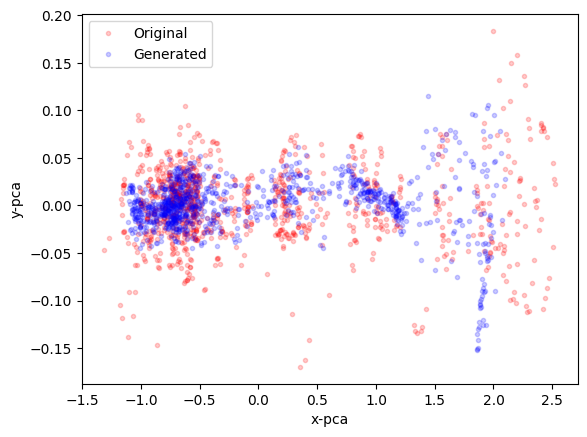

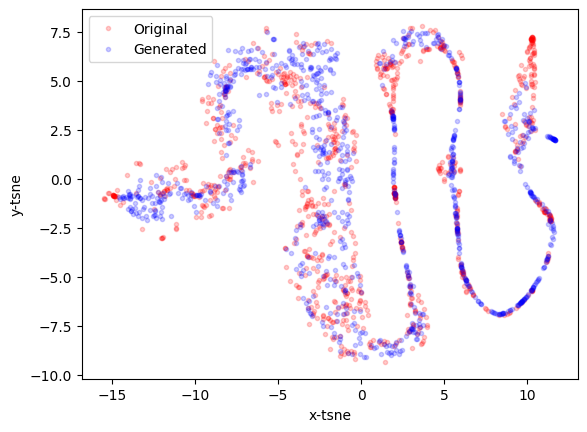

In [ ]:
# Plot real and generated distributions
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'pca'), 'pca')
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'tsne'), 'tsne')